# Data Wrangling (WeRateDogs Data)

![Image via Boston Magazine](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd378f_dog-rates-social/dog-rates-social.jpg)
<div style="text-align: center"><i>Image via <a href="https://www.bostonmagazine.com/arts-entertainment/2017/04/18/dog-rates-mit/">Boston Magazine</i></div>

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering</a></li>
<li><a href="#assessing">Assessing</a></li>
<li><a href="#cleaning">Cleaning</a></li>
<li><a href="#iterating">Iterating</a></li>
<li><a href="#storing">Storing</a></li>
<li><a href="#acting">Acting</a></li>
</ul>

<a id='intro'></a>
## Introduction
<div style="text-align:justify">
<br>
    <a href="https://twitter.com/dog_rates?lang=en">WeRateDogs</a> is a Twitter account that rates people's dogs with a humorous comment about the dog. Their Twitter account data as many other real world cases does not comes clean, so as part of the Udacity's Data Analyst Nanodegree program the data wrangling process must be applied in order to obtain data that will be useful to create interesting and trustworthy analyses and visualizations of these rates.
</div>

### Objectives

- Gathering: Gather data from three different sources in order to create a master dataset **(WeRateDogs Twitter archive, Image predictions file and Twitter API)**.

- Assesing: Assess both visually and programatically for quality and tidiness issues. Detect and document at least **8 quality issues and 2 tidiness issues**.

- Cleaning: Clean each of the issues you documented while assessing. **The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate)**.

- Storing: Store the clean DataFrame(s) in a CSV file with the main one. **Additionally, store the cleaned data in a SQLite database**.

- Acting: Analyze and visualize the wrangled data, **producing at least 3 insights and 1 visualization**.

In [221]:
# prerequisite package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# library for HTTP request
import requests

# libaries for os interfaces interaction
import os
import filecmp

# library for Twitter API
import tweepy
from tweepy import OAuthHandler

# library to handle json
import json
import collections

# package to calculate time
from timeit import default_timer as timer

%matplotlib inline

<a id='gathering'></a>
## Gathering the Data

The first source that will be gather is the WeRateDogs Twitter archive, this file has been downloaded manually from the following url: [Data source 1](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv).

After the download, I transferred the file to the * src * folder located in the main directory of this notebook. Once there we read the file using the `read_csv` function from Pandas.

In [255]:
folder_name = 'src'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

twitter_archive = pd.read_csv('src/twitter-archive-enhanced.csv')
twitter_archive.head();

In [256]:
#Then we look that the data has been loaded properly by checking its info
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Now the second source that will be gather is the Image Predictions file, which is hosted on [Udacity's servers](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv) and should be programmatically downloaded, for this purpose we use the `request` library.

In [8]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
#We here try to made a http GET request to obtain the files from the server
response = requests.get(url)
if response.status_code == 200:
    print('Sucessful request')
else:
    print('The request was not sucessful:' + str(response.status_code))

Sucessful request


In [9]:
# If the request was sucessful, now we proceed to save the tsv file
with open(os.path.join(folder_name,
                       url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [15]:
# If the file has been sucessfully saved into the src folder, then we just
# have to assert that the number of files in that directory
assert len(os.listdir('src')) == 3

In [452]:
# Finally we just have to read the file, using pandas
image_predictions = pd.read_csv('src/image-predictions.tsv', sep="\t")
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
#Then we look that the data has been loaded properly by checking its info
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Finally the third source will be gather using Twitter's API, the library `tweepy` allow us to to interact with the API using Python.

In [21]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [ ]:
# The tokens for authetication must be HIDDEN for security reasons and
# comply with Twitter's Terms and Conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_token_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Then we create an instance of the API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [74]:
# Next we extract the ids from twitter-archive-enhanced dataset
query_ids = twitter_archive['tweet_id'].values
tweets = len(query_ids)

In [ ]:
# Once having all the ids, we query Twitter's API for information from each Tweet
# Twitter will return JSON data, so we must dump it into a file

# These variables will help to keep on check on how is going the process
# and retrieve failed tweets
gauge = 0
start = timer()
failed_tweets = {}

with open('src/tweets_json.txt', mode='w') as output:   
    for tweet_id in query_ids:
        gauge += 1
        # Progress message
        print("Retrieving: " + str(tweet_id) + 
              "  Missing: " + str(tweets-gauge))
        try:
            # Get the tweet query status
            # Pass in 'extended' to get non truncated tweet text
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Sucess")
            json.dump(tweet.json, output)
            output.write("\n")
        # In case that Twitter responds with an error
        except tweepy.TweepError as e:
            print("Failure")
            # We make a dictionary with the tweets that throwed errors
            # for future handling
            failed_tweets[tweet_id] = e
            pass
end = timer()
print("Total Time: " + str(end-start))
print("Errors:")
print(failed_tweets)

In [66]:
# Now we read the dumped txt file, and append each tweet in a list
tweets = []
for line in open('src/tweets_json.txt', 'r'):
    tweets.append(json.loads(line))
# We verify the amount of tweets
len(tweets)

2354

In [67]:
# Then we explore the structure of the tweet in order to find the information that we want:
tweets[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'medium': {'w': 

> Once the tweets have been appended to the list, we extract the additional data that we want so we can build a dictionary, and finally construct the dataframe. The variables that will be extracted are:
- *id*
- *retweet_count*
- *favorite_count*

In [82]:
# We create lists that will hold each variable of the tweets
tweet_ids = []
retweet_counts = []
favorite_counts = []

for tweet in tweets:
    tweet_ids.append(tweet['id'])
    retweet_counts.append(tweet['retweet_count'])
    favorite_counts.append(tweet['favorite_count'])
    
# Now we construct the dataframe from a dictionary with the previous data
data = {'tweet_id':tweet_ids, 'retweet_count':retweet_counts, 'favorite_count':favorite_counts} 
tweets_counts = pd.DataFrame(data)
tweets_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


> Now we have all the sources and data required for this project, we proceed to assess each dataset in order to find quality and tideness issues.

<a id='assessing'></a>
## Assesing Data

### Visual Assessment
The very first step when assessing the data is to do it visually, even though this might not be effective for large datasets, it will help us to get acquainted with the data.

#### Twitter Archive Dataset

In [90]:
# Display the twitter archive table
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


> Indentified issues:
- Missing values for columns: (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id).
- There is no information about the type of dog, 'None' value for columns: (doggo, floofer, pupper, puppo).
- `source` column has embedded HTML code.

`twitter_archive` columns:
- **tweet_id**: is the tweet identifier.
- **in_reply_to_status_id**: reply status identifier.
- **in_reply_to_user_id**: reply to user identifier.
- **timestamp** the timestamp assigned to each tweet when it is created.
- **source**: the source (mobile) from which the tweet was made.
- **text**: the text (body) that each tweet has (during that time Twitter only allowed texts of 140 characters max).
- **retweeted_status_id**: identifier of the status if this tweet was retweeted.
- **retweeted_status_user_id**: identifier of the user if this tweet was retweeted.
- **retweeted_status_timestamp**: the timestamp given if this tweet was retweeted.
- **expanded_urls**: expanded urls.
- **rating_numerator**: numerator of the ranking, almost always above 10.
- **rating_denominator**: denominator of the ranking, fixed to 10.
- **name**: the given name to the dog.
- **doggo**: a type of dog. A big pupper, usually older. This label does not stop a doggo from behaving like a pupper.
- **floofer**: a type of dog. A any dog really. However, this label is commonly given to dogs with semmingly excess fur.
- **pupper**: a type of dog. A small doggo, usually younger. Can be equally, if not more mature than some doggos.
- **puppo**: a type of dog. A transitional state between pupper and doggo. Easily understood as the dog equivalent of a teenager.

**Definitions for dogs were taken from:** *TheDogtionary (via the #WeRateDogs book on Amazon)*

In [92]:
# Display the image predictions table
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


> Indentified issues:
- Some breeds are capitalized while others not, also instead of a space the character '_' is used, for columns: (p1, p2, p3)

`image_predictions` columns:
- **tweet_id**: is the tweet identifier.
- **jpg_url**: the url to the image of the dog used for the prediction.
- **img_num**: number of image.
- **p1**: p1 is the algorithm's #1 prediction for the image in the tweet.
- **p1_conf**: p1_conf is how confident the algorithm is in its #1 prediction.
- **p1_dog**: p1_dog is whether or not the #1 prediction is a breed of dog.
- **p2**: p2 is the algorithm's second most likely prediction.
- **p2_conf**: p2_conf is how confident the algorithm is in its #2 prediction.
- **p2_dog**: p2_dog is whether or not the #2 prediction is a breed of dog.
- **p3**: p3 is the algorithm's third most likely prediction.
- **p3_conf**: p2_conf is how confident the algorithm is in its #3 prediction.
- **p3_dog**: p2_dog is whether or not the #3 prediction is a breed of dog.

In [93]:
# Display the tweets counts table
tweets_counts.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


`tweets_counts` columns:
- **tweet_id**: is the tweet identifier.
- **retweet_count**: number of retweets of that tweet.
- **favorite_count**: number of favourites of that tweet.

### Programmatic Assesment
Now programmatically we will look for quality and tidiness issues in the datasets, using pandas functions.

### Twitter Archive

In [96]:
# Look for dimensions
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

> Indentified issues:
- Remove retweets
- These columns are not needed since they are retweets: (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id).
- Timestamp columns as strings, not datetime.

In [231]:
# Now all the denominators are fixed to 10
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

**The previous information is pretty interesting, leets look further into these values, since is our main metric**

In [160]:
# Lets look at those tweets with different denominators
twitter_archive[twitter_archive.rating_denominator < 10][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian...,1,2


In [140]:
# Something seems odd about text and the numerators, leets look at them
texts = twitter_archive[twitter_archive.rating_denominator < 10]['text'].values
for i in range(len(texts)):
    print("Text " + str(i+1)+ ":" + texts[i])

Text 1:@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Text 2:Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Text 3:This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


> From these tweets we can detect what was the correct rating. Except for the case of Sam, which actually refers that she smiles all the day.
- Tweets (835246439529840640, 666287406224695296) [13/10, 9/10] - Incorrect rating
- Tweet (810984652412424192) - Invalid rating

In [161]:
twitter_archive[twitter_archive.rating_denominator > 100][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
902,758467244762497024,Why does this never happen at my front door......,165,150
1120,731156023742988288,Say hello to this unbelievably well behaved sq...,204,170
1634,684225744407494656,"Two sneaky puppers were not initially seen, mo...",143,130
1635,684222868335505415,Someone help the girl is being mugged. Several...,121,110
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120


In [152]:
# Both numerator and denominator seem to be pretty high, lets look at the text to see why.
# Something seems odd about text and the numerators, leets look at them
texts = twitter_archive[twitter_archive.rating_denominator > 100]['text'].values
for i in range(len(texts)):
    print("Text " + str(i+1)+ ":" + texts[i])

Text 1:Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
Text 2:Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Text 3:Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3
Text 4:Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55
Text 5:IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq


> If we look at each one of these tweets, we realize that the score given is for all the dogs that we can observe (who are represented by the denominator * 10)
>
> - Tweets (758467244762497024, 731156023742988288, 684225744407494656, 684222868335505415, 677716515794329600) - Adjust rating

In [163]:
twitter_archive[(twitter_archive.rating_denominator > 10) & 
                (twitter_archive.rating_denominator < 100)][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the flo...,84,70
784,775096608509886464,"RT @dog_rates: After so many requests, this is...",9,11
1068,740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #Final...,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very pre...,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro...",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll ...,60,50


In [153]:
# Both numerator and denominator seem to be pretty high, lets look at the text to see why.
# Something seems odd about text and the numerators, leets look at them
texts = twitter_archive[(twitter_archive.rating_denominator > 10) & 
                (twitter_archive.rating_denominator < 100)]['text'].values
for i in range(len(texts)):
    print("Text " + str(i+1)+ ":" + texts[i])

Text 1:@docmisterio account started on 11/15/15
Text 2:The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
Text 3:RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
Text 4:After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Text 5:Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
Text 6:This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Text 7:Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
Text 8:Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
Text 9:From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https:/

> **Fact: Dogs who died at the terrorist attack of 9/11 are rated wrong, instead they are granted with one of the highest grades possible: 14/10. This is pretty sad :(**  
>
> - Tweets: (775096608509886464, 740373189193256964, 716439118184652801, 682962037429899265, 722974582966214656) [14/10, 14/10, 11/10, 10/10, 13/10] - Incorrect rating
>
> - Some "ratings" are confused with the date when an account was created. 
> Tweet: (832088576586297345) - Invalid rating
>
> - Same issue as the one that was mentioned for some tweets that involve 2 or more dogs. Tweets: (820690176645140481, 713900603437621249, 710658690886586372, 709198395643068416, 704054845121142784, 697463031882764288, 675853064436391936) - Adjust rating

In [164]:
# Lets look a the more extreme outliers
twitter_archive[twitter_archive.rating_numerator > 400][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,855860136149123072,@s8n You tried very hard to portray this good ...,666,10
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
979,749981277374128128,This is Atticus. He's quite simply America af....,1776,10
2074,670842764863651840,After so many requests... here you go.\n\nGood...,420,10


In [159]:
# Making aside the tweet that was previously analized, the others seem to have normal denominators, lets see why
texts = twitter_archive[twitter_archive.rating_numerator > 400]['text'].values
for i in range(len(texts)):
    print("Text " + str(i+1)+ ":" + texts[i])

Text 1:@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
Text 2:@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
Text 3:@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Text 4:This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Text 5:After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY


**Looking at these tweets we realize something pretty funny about all of them, the one with 1776/10 makes reference to the independence year of USA, the one with 666 makes reference to the "number of the beast", and the ones with 420 are not dogs, but the rapper Snop Dog xD**

> Since they are special cases, we might consider to remove them, or do not take them into account for further analysis.
> Tweets: (855862651834028034, 855860136149123072, 749981277374128128, 670842764863651840)

> **Note: Using NLP for the tweets who present abnormalities is an interesenting option, in order to reduce the time and automatize this activity.**

In [110]:
# Now we will look at the types of dogs and their names
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Lola          10
Tucker        10
Penny         10
Bo             9
Winston        9
the            8
Sadie          8
Daisy          7
Buddy          7
an             7
Bailey         7
Toby           7
Stanley        6
Jack           6
Rusty          6
Milo           6
Oscar          6
Scout          6
Leo            6
Jax            6
Dave           6
Koda           6
Bella          6
George         5
            ... 
Dixie          1
Simba          1
Ebby           1
by             1
Amber          1
Emmie          1
Grizzwald      1
Tiger          1
Sky            1
Jebberson      1
Sephie         1
Todo           1
Lenox          1
his            1
Lorelei        1
Malikai        1
Eleanor        1
Charl          1
Snoop          1
Rooney         1
Sid            1
Duddles        1
Bertson        1
Daniel         1
Brooks         1
Jerome         1
Traviss        1
Mairi         

> This column presents come problems and it will involve just too much time cleaning it...

In [195]:
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [113]:
twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [116]:
twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [120]:
twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

> Given the values of the previous columns, it will be better to take it as a integer column with 0's and 1's, instead of strings.

In [101]:
# We will see if have duplicates id in the dataset.
twitter_archive.tweet_id.nunique()

2356

> It seems that for this dataset we do not have duplicates.

### Image predictions

In [197]:
# Look for dimensions
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> - At first sight it seems that there are no missing values, and that each data type is correct.
> - The columns are not informative enough.

In [198]:
# Now lets verify if there are not duplicated tweets
image_predictions.tweet_id.nunique()

2075

In [216]:
# We verify the values of the breed columns
print("p1:" + str(image_predictions.p1.nunique()))
print("p2:" + str(image_predictions.p2.nunique()))
print("p3:" + str(image_predictions.p3.nunique()))

p1:378
p2:405
p3:408


In [206]:
# We verify which values are in the column p1
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
web_site                      19
Cardigan                      19
teddy                         18
Eskimo_dog                    18
beagle                        18
Maltese_dog                   18
Shetland_sheepdog             18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
Italian_greyhound             16
kuvasz                        16
          

> There are values that are not breeds and correspond to objects, not dogs. We need to be aware from these value when we select type of breed from p1, p2 or p3.

In [223]:
# Now lets look at duplicated urls
print(image_predictions[image_predictions.jpg_url.duplicated()].count())
image_predictions[image_predictions.jpg_url.duplicated(keep = False)].sort_values(
    by = 'jpg_url').head()

tweet_id    66
jpg_url     66
img_num     66
p1          66
p1_conf     66
p1_dog      66
p2          66
p2_conf     66
p2_dog      66
p3          66
p3_conf     66
p3_dog      66
dtype: int64


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1864,842892208864923648,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1641,807106840509214720,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True
1703,817181837579653120,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1,Tibetan_mastiff,0.506312,True,Tibetan_terrier,0.295690,True,otterhound,0.036251,True


In [230]:
# Now we verify those url in the twitter archive and try to guess why they are equal
twitter_archive[twitter_archive.tweet_id.isin([675354435921575936, 752309394570878976, 842892208864923648, 807106840509214720])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
260,842892208864923648,NaN,NaN,2017-03-18 00:15:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,8.071068e+17,4.196984e+09,2016-12-09 06:17:20 +0000,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
534,807106840509214720,NaN,NaN,2016-12-09 06:17:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
949,752309394570878976,NaN,NaN,2016-07-11 01:11:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Everyone needs to watch this. 1...,6.753544e+17,4.196984e+09,2015-12-11 16:40:19 +0000,https://twitter.com/dog_rates/status/675354435...,13,10,None,None,None,None,None
1865,675354435921575936,NaN,NaN,2015-12-11 16:40:19 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Everyone needs to watch this. 13/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675354435...,13,10,None,None,None,None,None


> Here we can notice that the duplicates belong to retweets, so we must do a double check to verify if they were all removed.

### Tweets counts

In [196]:
# Look for dimensions
tweets_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [169]:
# Now look for duplicated tweets id
tweets_counts.tweet_id.nunique()

2354

In [175]:
tweets_counts.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


**Now we will look at the values distribution**

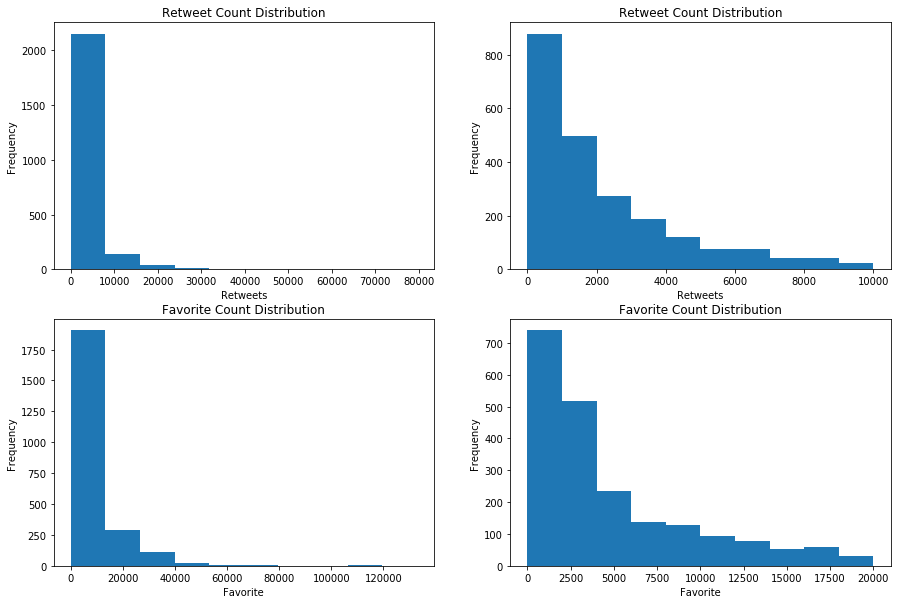

In [194]:
# We will show two plots, one without limits, and other with limit at x=10,000
plt.figure(figsize=[15,10])

plt.subplot(2,2,1)
plt.hist(data = tweets_counts, x = 'retweet_count');
plt.title("Retweet Count Distribution")
plt.xlabel('Retweets')
plt.ylabel('Frequency')

plt.subplot(2,2,2)
plt.hist(data = tweets_counts, x = 'retweet_count', range=(0,10000));
plt.title("Retweet Count Distribution")
plt.xlabel('Retweets')
plt.ylabel('Frequency')

plt.subplot(2,2,3)
plt.hist(data = tweets_counts, x = 'favorite_count');
plt.title("Favorite Count Distribution")
plt.xlabel('Favorite')
plt.ylabel('Frequency')

plt.subplot(2,2,4)
plt.hist(data = tweets_counts, x = 'favorite_count', range=(0,20000));
plt.title("Favorite Count Distribution")
plt.xlabel('Favorite')
plt.ylabel('Frequency');

> From the previous statistics and plots we can see that the distribution is right skewed, with some tweets (outliers) that we should be aware of.

### Observations
### Quality
`twitter_achive table`
- There are rows that belong to retweets, we should get rid of this rows.
- These columns are not needed since they belong to retweets: (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id).
- Incorrect datatype for the column 'timestamp', instead of string it should be datetime.
- Incorrect datatype for the columns *(doggo, floofer, pupper, puppo)* they are string when they only have two possible values, so they should be boolean datatype. 
- The rate assigned to the following tweets is incorrect, they should be corrected. Tweets (835246439529840640, 666287406224695296, 775096608509886464, 740373189193256964, 716439118184652801, 682962037429899265, 722974582966214656) [14/10, 14/10, 11/10, 10/10, 13/10, 13/10, 9/10] - Incorrect rating
- The rate assigned to the following tweets is for all the dogs that appear on it, so the values should be recalculated. Tweets (758467244762497024, 731156023742988288, 684225744407494656, 684222868335505415, 677716515794329600, 820690176645140481, 713900603437621249, 710658690886586372, 709198395643068416, 704054845121142784, 697463031882764288, 675853064436391936) - Adjust rating
- These tweets do not have valid ratings and there is no futher information that we can use, so they should be removed. Tweets (810984652412424192, 855862651834028034, 855860136149123072, 749981277374128128, 670842764863651840 )

`image_predictions table`
- Columns: *(p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)* are not informative enough.
- There are values that are not breeds of dogs. (We need to be aware from these value when we select type of breed from p1, p2 or p3).
- Duplicated urls that belong to retweets.
- In the columns *(p1, p2, p3)* all the values should be converted to lower case to avoid misspelling.

### Tidiness
- There are 2075 rows in `image_prediction table`, 2356 in `tweet_archive table`, and 2354 `tweets_count table`. 
- The information from the table `tweets_counts` should be part of `twitter_archive`, since contains information of each tweet.
- Since we are only interested in the breed of the dog, that column should be part of `twitter_archive` table (In addition to this, we might consider only merge the columns thhat belong to the most confident prediction of a dog).
- At the end we only need 1 a table that contains all the data relevant for our analysis (observational unit).

<a id='cleaning'></a>
## Cleaning Data

#### Making a copy of the three datasets

In [608]:
# First of all we make a copy of the three datasets before we start cleaning
twitter_archivecp = twitter_archive.copy()
image_predictionscp = image_predictions.copy()
tweets_countscp = tweets_counts.copy()

### Missing Data

`twitter_archivecp`

#### Define
- Remove all the rows that belong to retweets.
- Remove columns that are associated with retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id).
- Remove all the rows that contain tweets that have no valid ratings: (810984652412424192, 855862651834028034, 855860136149123072, 749981277374128128, 670842764863651840 )

#### Code

In [609]:
# First we obtain all the tweets that have null values in the parameters that belong to retweets
twitter_archivecp = twitter_archivecp[(twitter_archivecp.retweeted_status_user_id.isnull()) & 
                (twitter_archivecp.retweeted_status_id.isnull()) & 
                (twitter_archivecp.retweeted_status_timestamp.isnull()) & 
                (twitter_archivecp.in_reply_to_status_id.isnull()) & 
                (twitter_archivecp.in_reply_to_user_id.isnull())]

In [610]:
# Drop all the columns that are associated with retweets
twitter_archivecp.drop(['retweeted_status_id', 'retweeted_status_user_id',
                      'retweeted_status_timestamp', 'in_reply_to_status_id',
                      'in_reply_to_user_id'], inplace=True, axis=1)

In [611]:
# Finally we remove all the rows that have no valid strings
invalid_tweets = [810984652412424192, 855862651834028034, 855860136149123072, 749981277374128128, 670842764863651840]
indexes = twitter_archivecp.index[twitter_archivecp.tweet_id.isin(invalid_tweets)].tolist()
indexes

[516, 979, 2074]

In [612]:
twitter_archivecp.drop(indexes, inplace=True)

#### Test

In [613]:
twitter_archivecp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null object
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2091 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: int64(3), object(9)
memory usage: 212.7+ KB


In [614]:
assert twitter_archivecp[twitter_archivecp.tweet_id.isin(invalid_tweets) == True].shape[0]== 0

#### Define
- Convert to datetime the datatype of the column 'timestamp'
- Convert to boolean (integer values of 0 and 1) datatype the columns 'doggo', 'floofer', 'pupper', 'puppo'

#### Code

In [615]:
# Convert to datetime the column timestamp
twitter_archivecp.timestamp = pd.to_datetime(twitter_archivecp.timestamp, infer_datetime_format=True)

In [616]:
# Convert to boolean the columns 'doggo', 'floofer', 'pupper', 'puppo'
columns = ['doggo', 'floofer', 'pupper', 'puppo']
for column in columns:
    twitter_archivecp[column] = twitter_archivecp[column].replace({column:1, 'None':0})

#### Test

In [617]:
# We verify that the convertion was sucessful
twitter_archivecp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2091 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null int64
floofer               2094 non-null int64
pupper                2094 non-null int64
puppo                 2094 non-null int64
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 212.7+ KB


#### Define
- Correct the ratings for the following tweets: (835246439529840640, 666287406224695296, 775096608509886464, 740373189193256964, 716439118184652801, 682962037429899265, 722974582966214656). Ratings: [14/10, 14/10, 11/10, 10/10, 13/10, 13/10, 9/10].

#### Code

In [618]:
# First of all we have to verify which tweets were not deleted (retweets) and the we proceed to correct the ratings
verify_tweets = [835246439529840640, 666287406224695296, 775096608509886464, 740373189193256964, 716439118184652801, 682962037429899265, 722974582966214656]

twitter_archivecp[twitter_archivecp.tweet_id.isin(verify_tweets) == True]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,0,0,0,0
1165,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,None,0,0,0,0
1202,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,0,0,0,0
1662,682962037429899265,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,0,0,0,0
2335,666287406224695296,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1,2,an,0,0,0,0


In [619]:
# For the ones who were not deleted we proceed to adjust the ratings
adjust_tweets = [740373189193256964, 722974582966214656, 716439118184652801, 682962037429899265, 666287406224695296]
ratings = [[10,10], [9,10], [13,10], [13,10], [14,10]]
indexes = twitter_archivecp.index[twitter_archivecp.tweet_id.isin(adjust_tweets)].tolist()
indexes

[1068, 1165, 1202, 1662, 2335]

In [620]:
for i in range(len(indexes)):
    twitter_archivecp.loc[indexes[i], 'rating_numerator'] = ratings[i][0]
    twitter_archivecp.loc[indexes[i], 'rating_denominator'] = ratings[i][1]

#### Test

In [621]:
# Now we verify that the values had been replaced
twitter_archivecp[twitter_archivecp.tweet_id.isin(verify_tweets) == True]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,10,10,None,0,0,0,0
1165,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,9,10,None,0,0,0,0
1202,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,13,10,Bluebert,0,0,0,0
1662,682962037429899265,2016-01-01 16:30:13,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,13,10,Darrel,0,0,0,0
2335,666287406224695296,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,14,10,an,0,0,0,0


#### Define
- Recalculate and correct the ratings for the following tweets: (758467244762497024, 731156023742988288, 684225744407494656, 684222868335505415, 677716515794329600, 820690176645140481, 713900603437621249, 710658690886586372, 709198395643068416, 704054845121142784, 697463031882764288, 675853064436391936)

#### Code

In [622]:
# First of all we have to verify which tweets were not deleted (retweets) and the we proceed to correct the ratings
recalculate_tweets = [758467244762497024, 731156023742988288, 684225744407494656, 684222868335505415, 677716515794329600, 820690176645140481, 713900603437621249, 710658690886586372, 709198395643068416, 704054845121142784, 697463031882764288, 675853064436391936]

twitter_archivecp[twitter_archivecp.tweet_id.isin(recalculate_tweets) == True]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,0,0,0,0
902,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,None,0,0,0,0
1120,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,this,0,0,0,0
1228,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,None,0,0,0,0
1254,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,None,0,0,0,0
1274,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,None,0,0,0,0
1351,704054845121142784,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,a,0,0,0,0
1433,697463031882764288,2016-02-10 16:51:59,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,https://twitter.com/dog_rates/status/697463031...,44,40,None,0,0,0,0
1635,684222868335505415,2016-01-05 04:00:18,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,https://twitter.com/dog_rates/status/684222868...,121,110,None,0,0,0,0
1779,677716515794329600,2015-12-18 05:06:23,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,https://twitter.com/dog_rates/status/677716515...,144,120,None,0,0,0,0


In [623]:
# Now we extract the indexes and we proceed to recalculate the rating values
indexes = twitter_archivecp.index[twitter_archivecp.tweet_id.isin(recalculate_tweets)].tolist()
indexes

[433, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1635, 1779, 1843]

In [624]:
#We recalculate the values
for index in indexes:
    number_of_dogs = twitter_archivecp.loc[index, 'rating_denominator']/10
    twitter_archivecp.loc[index, 'rating_numerator'] = int(twitter_archivecp.loc[index, 'rating_numerator']/number_of_dogs)
    twitter_archivecp.loc[index, 'rating_denominator'] = 10

#### Test

In [625]:
twitter_archivecp[twitter_archivecp.tweet_id.isin(recalculate_tweets) == True]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,12,10,None,0,0,0,0
902,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,11,10,None,0,0,0,0
1120,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,12,10,this,0,0,0,0
1228,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,11,10,None,0,0,0,0
1254,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,10,10,None,0,0,0,0
1274,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,9,10,None,0,0,0,0
1351,704054845121142784,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,12,10,a,0,0,0,0
1433,697463031882764288,2016-02-10 16:51:59,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,https://twitter.com/dog_rates/status/697463031...,11,10,None,0,0,0,0
1635,684222868335505415,2016-01-05 04:00:18,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,https://twitter.com/dog_rates/status/684222868...,11,10,None,0,0,0,0
1779,677716515794329600,2015-12-18 05:06:23,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,https://twitter.com/dog_rates/status/677716515...,12,10,None,0,0,0,0


#### Define

`image_predictions table`
- Convert values of columns (p1,p2,p3) to lowercase
- Rename the columns (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog) to (prediction_#, conf_probability_#, predicted_breed_#), where # is the number 1,2 and 3.
- Verify that there is no more duplicated urls due to retweets.
- Remove those registers in which neither of the 3 predictions are dogs.

#### Code

In [626]:
# We convert the columns 'p1', 'p2' and 'p3' to lowercase
columns = ['p1', 'p2', 'p3']
for column in columns:
    image_predictionscp[column] = image_predictionscp[column].str.lower()

In [627]:
# Now we rename the columns (p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog)
image_predictionscp.rename(columns={"p1": "prediction_1", "p2": "prediction:_2", "p3": "prediction:_3", 
                                    "p1_conf": "conf_probability_1", "p2_conf": "conf_probability_2", 
                                    "p3_conf": "conf_probability_3", "p1_dog": "predicted_breed_1",
                                    "p2_dog": "predicted_breed_2", "p3_dog": "predicted_breed_3",}, inplace=True);

In [ ]:
# We add a new column in which we will save the breed (in case of a dog) or object with the highest probaility
# and another column which states that if it is a dog or not.
# Remove all the rows in which neither of the 3 predictions are dogs
indexes = image_predictionscp.index[((image_predictionscp.predicted_breed_1) | 
                    (image_predictionscp.predicted_breed_2) | 
                    (image_predictionscp.predicted_breed_3)) == False].tolist()


In [589]:
# Remove all the rows in which neither of the 3 predictions are dogs
indexes = image_predictionscp.index[((image_predictionscp.predicted_breed_1) | 
                    (image_predictionscp.predicted_breed_2) | 
                    (image_predictionscp.predicted_breed_3)) == False].tolist()
image_predictionscp.drop(indexes, inplace=True)

In [590]:
# Verify that there is no more duplicated urls due to retweets
# Now lets look at duplicated urls
indexes = image_predictionscp[image_predictionscp.jpg_url.duplicated(keep = False)].sort_values(
    by = 'jpg_url').index
len(indexes)

120

#### Test

In [591]:
image_predictionscp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id              1751 non-null int64
jpg_url               1751 non-null object
img_num               1751 non-null int64
prediction_1          1751 non-null object
conf_probability_1    1751 non-null float64
predicted_breed_1     1751 non-null bool
prediction:_2         1751 non-null object
conf_probability_2    1751 non-null float64
predicted_breed_2     1751 non-null bool
prediction:_3         1751 non-null object
conf_probability_3    1751 non-null float64
predicted_breed_3     1751 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


In [592]:
twitter_archivecp[twitter_archivecp.index.isin(indexes)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
85,876120275196170240,2017-06-17 16:52:05,"<a href=""http://twitter.com/download/iphone"" r...","Meet Venti, a seemingly caffeinated puppoccino...",https://twitter.com/dog_rates/status/876120275...,13,10,Venti,0,0,0,0
224,849336543269576704,2017-04-04 19:03:06,"<a href=""http://twitter.com/download/iphone"" r...",At first I thought this was a dog because of t...,https://twitter.com/dog_rates/status/849336543...,11,10,None,0,0,0,0
241,846505985330044928,2017-03-27 23:35:28,"<a href=""http://twitter.com/download/iphone"" r...",THIS WAS NOT HIS FAULT HE HAD NO IDEA. 11/10 S...,https://twitter.com/shomaristone/status/846484...,11,10,None,0,0,0,0
432,820749716845686786,2017-01-15 21:49:15,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sunny. He can take down a polar bear in o...,https://twitter.com/dog_rates/status/820749716...,13,10,Sunny,0,0,0,0
480,815736392542261248,2017-01-02 01:48:06,"<a href=""http://twitter.com/download/iphone"" r...",This is Akumi. It's his birthday. He received ...,https://twitter.com/dog_rates/status/815736392...,11,10,Akumi,0,0,0,0
587,799757965289017345,2016-11-18 23:35:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Sobe. She's a h*ckin happy doggo. Only...,https://twitter.com/dog_rates/status/799757965...,13,10,Sobe,1,0,0,0
591,799063482566066176,2016-11-17 01:35:54,"<a href=""http://twitter.com/download/iphone"" r...",This is Mister. He only wears the most fashion...,https://twitter.com/dog_rates/status/799063482...,11,10,Mister,0,0,0,0
713,784183165795655680,2016-10-07 00:06:50,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Reginald. He's one magical puppo. Aero...,https://vine.co/v/5ghHLBMMdlV,12,10,Reginald,0,0,0,1
915,757354760399941633,2016-07-24 23:20:20,"<a href=""http://twitter.com/download/iphone"" r...","This is Devón (pronounced ""Eric""). He forgot h...",https://twitter.com/dog_rates/status/757354760...,8,10,Devón,0,0,0,0
985,749075273010798592,2016-07-02 03:00:36,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Boomer. He's self-baptizing. Other dog...,https://vine.co/v/5ztZvHgI17r,11,10,Boomer,1,0,0,0


> Seems that there are not more retweets :)

<a id='iterating'></a>
## Additional Assessing and Cleaning (Iteration)

### Programmatic Assessment

In [593]:
# Let's look if there are any rates that are inconsistent
twitter_archivecp.rating_numerator.value_counts()

12    490
10    438
11    418
13    289
9     154
8      98
7      51
14     39
5      34
6      32
3      19
4      15
2       9
1       4
75      1
26      1
27      1
0       1
Name: rating_numerator, dtype: int64

> There are 3 values that are suspicious, lets dig in!

In [594]:
twitter_archivecp[twitter_archivecp.rating_numerator > 20]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,0,0,0,0
763,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,0,0,1,0
1712,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,0,0,0,0


In [595]:
texts = twitter_archivecp[twitter_archivecp.rating_numerator > 20]['text'].values

In [596]:
for i in range(len(texts)):
    print("Text " + str(i+1)+ ":" + texts[i])

Text 1:This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
Text 2:This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
Text 3:Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


> Reading at the text we notice that the problem was that the numerators are the decimal values of the rates.

### Quality
`twitter_archivecp`
- The rate assigned to the following tweets is incorrect, they should be corrected. Tweets: (786709082849828864, 778027034220126208, 680494726643068929) [10/10, 11/10, 11/10]

## Cleaning

#### Define
Correct the ratings for the following tweets: (786709082849828864, 778027034220126208, 680494726643068929). Ratings: [10/10, 11/10, 11/10].

#### Code

In [597]:
# For the ones who were not deleted we proceed to adjust the ratings
adjust_tweets = [786709082849828864, 778027034220126208, 680494726643068929]
ratings = [[10,10], [11,10], [11,10]]
indexes = twitter_archivecp.index[twitter_archivecp.tweet_id.isin(adjust_tweets)].tolist()
indexes

[695, 763, 1712]

In [598]:
for i in range(len(indexes)):
    twitter_archivecp.loc[indexes[i], 'rating_numerator'] = ratings[i][0]
    twitter_archivecp.loc[indexes[i], 'rating_denominator'] = ratings[i][1]

#### Test

In [599]:
# Now we verify that the values had been replaced
twitter_archivecp[twitter_archivecp.tweet_id.isin(adjust_tweets) == True]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,10,10,Logan,0,0,0,0
763,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11,10,Sophie,0,0,1,0
1712,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11,10,None,0,0,0,0


## Tidiness

- Combine the 3 tables together into a single table named: `twitter_archive_master.csv`
- Drop the columns that will be not part of the analysis.

In [606]:
twitter_archive_master = twitter_archivecp.merge(tweets_countscp, on = 'tweet_id', how = 'left')
twitter_archive_master = twitter_archive_master.merge(image_predictionscp, 
  on = 'tweet_id', how = 'left')

In [607]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 25 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2091 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null int64
floofer               2094 non-null int64
pupper                2094 non-null int64
puppo                 2094 non-null int64
retweet_count         2094 non-null int64
favorite_count        2094 non-null int64
jpg_url               1665 non-null object
img_num               1665 non-null float64
prediction_1          1665 non-null object
conf_probability_1    1665 non-null float64
predicted_breed_1     1665 non-null object
prediction:_2         1665 non-null object
conf_probability_2    1665 non-n

In [ ]:
twitter_archive_master.drop(['source', 'text', 'expanded_urls'], 
  inplace = True, axis = 1)

- There are 2075 rows in `image_prediction table`, 2356 in `tweet_archive table`, and 2354 `tweets_count table`. 
- The information from the table `tweets_counts` should be part of `twitter_archive`, since contains information of each tweet.
- Since we are only interested in the breed of the dog, that column should be part of `twitter_archive` table (In addition to this, we might consider only merge the columns thhat belong to the most confident prediction of a dog).
- At the end we only need 1 a table that contains all the data relevant for our analysis (observational unit).